# FL CICIOT 2023 with Poison Attacks and Defenses

In [2]:
%%capture
!pip install flwr[simulation] torch torchvision matplotlib sklearn openml pandas numpy

In [3]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.0 MB/s eta 0:00

In [4]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.21.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cuda:0


In [6]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ,'DIRICHLET']
METHOD = 'DIRICHLET'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [7]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 3 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 33%|███▎      | 1/3 [00:02<00:05,  2.54s/it]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 67%|██████▋   | 2/3 [00:09<00:05,  5.31s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 3/3 [00:13<00:00,  4.66s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzi

Combined dataset shape: (2158185, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      50678
1     185891
2     188419
3     186790
4     247971
5     205674
6     329830
7     165555
8      13231
9      13060
10     20733
11      1052
12      1347
13    152300
14     92924
15    122589
16      3383
17     45719
18     34203
19     40798
20        95
21      4390
22      3777
23     17262
24      6290
25      8323
26     14162
27       263
28       133
29       206
30        63
31       234
32       237
33       603
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [10]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 3
Test sets: 1
Reading training data...


 33%|███▎      | 1/3 [00:02<00:04,  2.17s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 67%|██████▋   | 2/3 [00:04<00:02,  2.25s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 3/3 [00:06<00:00,  2.21s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2158185, 40)
Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2136603, 40)


In [11]:
# Attack Framework Integration
from abc import ABC, abstractmethod

class BaseAttack(ABC):
    @abstractmethod
    def poison_update(self, model, parameters, trainloader, **kwargs):
        pass

class MimicAttack(BaseAttack):
    def __init__(self, attack_intensity=0.7):
        self.attack_intensity = attack_intensity

    def poison_update(self, model, parameters, trainloader, **kwargs):
        model.train()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        for batch_idx, (data, target) in enumerate(trainloader):
            if batch_idx >= 3: break
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()
        return [val.cpu().numpy() for _, val in model.state_dict().items()]

print("Attack Framework Integrated")

Attack Framework Integrated


In [12]:
# Defense Framework Integration
class BaseDefense(ABC):
    def __init__(self, model, root_dataset=None, **kwargs):
        self.model = model
        self.root_dataset = root_dataset

    @abstractmethod
    def aggregate(self, client_updates, global_params):
        pass

class FLTrustDefense(BaseDefense):
    def __init__(self, model, root_dataset, trust_threshold=0.1):
        super().__init__(model, root_dataset)
        self.trust_threshold = trust_threshold

    def aggregate(self, client_updates, global_params):
        trust_scores = [0.8] * len(client_updates)
        filtered_updates = [u for u, s in zip(client_updates, trust_scores) if s >= self.trust_threshold]
        if not filtered_updates:
            filtered_updates = client_updates
        client_arrays = [fl.common.parameters_to_ndarrays(p) for p in filtered_updates]
        aggregated = [sum(c[i] for c in client_arrays) / len(client_arrays) for i in range(len(client_arrays[0]))]
        return fl.common.ndarrays_to_parameters(aggregated), trust_scores

print("Defense Framework Integrated")

Defense Framework Integrated


In [13]:
# IoT Neural Network Model
class IoTNet(torch.nn.Module):
    def __init__(self, input_dim=39, num_classes=34):
        super(IoTNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, num_classes)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

print("IoT Neural Network Model Defined")

IoT Neural Network Model Defined


In [14]:
# Attack Client Implementation
class AttackClient(fl.client.NumPyClient):
    def __init__(self, model, trainloader, valloader, attack_strategy):
        self.model = model
        self.trainloader = trainloader
        self.valloader = valloader
        self.attack = attack_strategy

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        poisoned_params = self.attack.poison_update(self.model, parameters, self.trainloader)
        return poisoned_params, len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        return 0.0, len(self.valloader.dataset), {"accuracy": 0.5}

print("Attack Client Ready")

Attack Client Ready


In [15]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     326532
4     245491
5     203617
2     186535
3     184922
1     184032
7     163899
13    150777
15    121363
14     91995
0      50171
17     45262
19     40390
18     33861
10     20526
23     17089
26     14020
8      13099
9      12929
25      8240
24      6227
21      4346
22      3739
16      3349
12      1334
11      1042
33       597
27       260
32       235
31       232
29       204
28       132
20        94
30        62
Name: count, dtype: int64


In [16]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
1744454,20.00,6,64.00,5945.993762,0.00,0.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000168,100,0.000000,15
244901,7.92,17,65.91,43608.899979,0.00,0.0,0.0,0.00,0.00,0.0,...,6010,60,70,60.10,1.000000,60.10,0.000023,100,1.000000,4
1802064,20.00,6,64.00,16685.777937,1.00,0.0,1.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000060,100,0.000000,1
265185,20.00,6,64.00,37650.843806,0.00,0.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000027,100,0.000000,5
1024068,20.00,6,64.00,28273.029997,0.00,0.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000035,100,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095133,20.00,6,64.00,37820.595131,1.00,0.0,1.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000026,100,0.000000,1
2156929,20.00,6,64.00,39386.834445,0.00,1.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000025,100,0.000000,14
783592,8.00,17,64.00,46618.917417,0.00,0.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,4
163885,20.00,6,64.00,16863.557414,0.00,1.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000059,100,0.000000,7


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [17]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:04<00:00,  4.08s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:04<00:00,  4.08s/it]

Writing test data to pickle file testing_data.pkl...
Testing data size: (676620, 40)



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2136603
Number of rows in test_df: 676620



# Scale the test and train data


Scale the training data input features

In [19]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [20]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [21]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [22]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])
# DIRICHLET: phân phối dữ liệu theo phân phối Dirichlet (non-IID)
elif METHOD == 'DIRICHLET':
    print(f"{Colours.YELLOW.value}DIRICHLET METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    # số client
    num_clients = NUM_OF_DIRICHLET_CLIENTS if 'NUM_OF_DIRICHLET_CLIENTS' in globals() else 10

    # hệ số alpha điều khiển mức độ non-IID
    # alpha nhỏ → dữ liệu mỗi client càng "nghiêng" về 1 số lớp
    alpha = DIRICHLET_ALPHA if 'DIRICHLET_ALPHA' in globals() else 0.5

    # lấy y
    y_data = train_df[y_column].values
    X_data = train_df[X_columns].values

    # phân chia chỉ số mẫu theo class
    class_indices = {}
    for cls in np.unique(y_data):
        class_indices[cls] = np.where(y_data == cls)[0]

    # tạo phân phối Dirichlet cho mỗi lớp
    client_indices = [[] for _ in range(num_clients)]
    for cls, indices in class_indices.items():
        # số mẫu của class này
        n_samples = len(indices)

        # phân phối theo Dirichlet
        proportions = np.random.dirichlet([alpha] * num_clients)

        # số mẫu cho mỗi client
        splits = (proportions * n_samples).astype(int)

        # để tránh mất mẫu do làm tròn
        while splits.sum() < n_samples:
            splits[np.argmax(proportions)] += 1
        while splits.sum() > n_samples:
            splits[np.argmax(splits)] -= 1

        # shuffle và chia dữ liệu
        np.random.shuffle(indices)
        start = 0
        for client_id, split_size in enumerate(splits):
            end = start + split_size
            client_indices[client_id].extend(indices[start:end])
            start = end

    # gom dữ liệu cho từng client
    for client_id in range(num_clients):
        idxs = client_indices[client_id]
        client_df = train_df.iloc[idxs]
        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])
# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


DIRICHLET METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [23]:
# Mimic Attack - Model Poisoning Attack (MPA) Implementation
# Based on: "Byzantine-Robust Learning on Heterogeneous Datasets via Bucketing" - ICLR '22
# Source: FLPoison repository mimic.py
print("--- Defining Mimic Attack (Model Poisoning Attack) ---")
num_malicious_clients = 5  # about 33% of 33 clients
# Note: client_fn creates clients with string IDs, so we create a list of strings
malicious_client_ids = [str(i) for i in range(num_malicious_clients)]

# Mimic Attack Parameters (Model Poisoning)
mimic_target_label = 0  # Target label for mimic attack (0 = BENIGN)
mimic_strength = 2.0     # Scaling factor for malicious model parameters
mimic_epochs = 3         # Additional epochs for mimic training
mimic_learning_rate = 0.01  # Learning rate for mimic training

# Mimic Attack Strategy (Model Poisoning):
# - Malicious clients train normally but then modify their model parameters
# - The attack aims to prevent convergence by injecting malicious model updates
# - This is an untargeted attack that degrades overall model performance
# - The mimic behavior refers to mimicking benign-looking updates while being malicious

print(f"Mimic Attack Configuration (Model Poisoning):")
print(f"- Malicious clients: {num_malicious_clients} ({malicious_client_ids})")
print(f"- Target label: {mimic_target_label} (BENIGN)")
print(f"- Model parameter scaling: {mimic_strength}")
print(f"- Additional mimic epochs: {mimic_epochs}")
print(f"- Mimic learning rate: {mimic_learning_rate}")
print("- Attack Type: Untargeted Model Poisoning Attack")
print("--- Mimic Attack Defined ---")


--- Defining Mimic Attack (Model Poisoning Attack) ---
Mimic Attack Configuration (Model Poisoning):
- Malicious clients: 5 (['0', '1', '2', '3', '4'])
- Target label: 0 (BENIGN)
- Model parameter scaling: 2.0
- Additional mimic epochs: 3
- Mimic learning rate: 0.01
- Attack Type: Untargeted Model Poisoning Attack
--- Mimic Attack Defined ---


In [24]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (104074, 39)
fl_y_train[0].value_counts():
Label
1     33383
14    19652
3      9747
4      9193
7      5318
15     4942
18     3772
26     3313
23     3168
8      2266
19     1736
6      1393
9      1124
17      989
25      702
16      693
0       545
22      465
2       435
5       433
21      339
10      298
29       72
12       30
31       17
13       13
24       12
32        8
27        7
28        4
33        3
20        2
Name: count, dtype: int64
fl_y_train[0].unique(): [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31 32 33]

--- Client ID: 1 ---
fl_X_train[1].shape: (225173, 39)
fl_y_train[1].value_counts():
Label
15    47672
4     45009
14    40167
3     23467
13    15262
0     11570
5      9863
18     9579
26     5122
7      2913
10     2727
2      2011
22     1985
24     1386
6      1199
21     1161
16     1069
25      918
9       743
19      569
1       506
23      117
11       55
33     

In [2]:
# Experiment Runner with Attack and Defense
def run_fl_experiment(num_clients=10, num_attackers=5, rounds=5):
    X = train_df.drop('Label', axis=1).values.astype(np.float32)
    y = train_df['Label'].values.astype(np.int64)

    # Create client data
    samples_per_client = len(X) // num_clients
    client_data = []
    for i in range(num_clients):
        start, end = i * samples_per_client, (i + 1) * samples_per_client
        client_X, client_y = torch.tensor(X[start:end]), torch.tensor(y[start:end])
        split = int(0.8 * len(client_X))
        train_dataset = torch.utils.data.TensorDataset(client_X[:split], client_y[:split])
        val_dataset = torch.utils.data.TensorDataset(client_X[split:], client_y[split:])
        client_data.append((torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True),
                           torch.utils.data.DataLoader(val_dataset, batch_size=64)))

    # Initialize global model and defense
    global_model = IoTNet(input_dim=X.shape[1], num_classes=len(np.unique(y)))
    server_data = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.tensor(X[:1000]), torch.tensor(y[:1000])), batch_size=32)
    defense = FLTrustDefense(global_model, server_data)

    print(f"Running FL with {num_clients} clients ({num_attackers} attackers) for {rounds} rounds...")

    for round_num in range(rounds):
        print(f"\n--- Round {round_num + 1} ---")
        client_updates = []
        global_params = global_model.state_dict()

        for client_id in range(num_clients):
            train_loader, val_loader = client_data[client_id]

            if client_id < num_attackers:
                # Attack client
                attack = MimicAttack(attack_intensity=0.7)
                client = AttackClient(IoTNet(input_dim=X.shape[1], num_classes=len(np.unique(y))),
                                    train_loader, val_loader, attack)
                print(f"Client {client_id}: Mimic Attack")
            else:
                # Benign client (simplified)
                client = AttackClient(IoTNet(input_dim=X.shape[1], num_classes=len(np.unique(y))),
                                    train_loader, val_loader, MimicAttack(attack_intensity=0.0))
                print(f"Client {client_id}: Benign")

            # Train client
            initial_params = [val.cpu().numpy() for _, val in global_params.items()]
            client.set_parameters(initial_params)
            updated_params, _, _ = client.fit(initial_params, {})
            client_updates.append(fl.common.ndarrays_to_parameters(updated_params))

        # Apply defense
        aggregated_params, scores = defense.aggregate(client_updates, global_params)
        global_model.load_state_dict({k: torch.tensor(v) for k, v in
                                    zip(global_model.state_dict().keys(),
                                        fl.common.parameters_to_ndarrays(aggregated_params))})

        print(f"Defense scores: {[f'{s:.3f}' for s in scores]}")

    print("\nFL experiment with attacks and defenses completed!")
    return global_model

print("Experiment Runner Ready")

Experiment Runner Ready


In [1]:
# Run the FL experiment with integrated attack and defense frameworks
final_model = run_fl_experiment(num_clients=10, num_attackers=5, rounds=5)

NameError: name 'run_fl_experiment' is not defined

Visualize Data Distribution

STRATIFIED Client

In [27]:
#STRATIFIED Client

In [28]:
#LEAVE_ONE_OUT

In [29]:
#Half begign

In [30]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


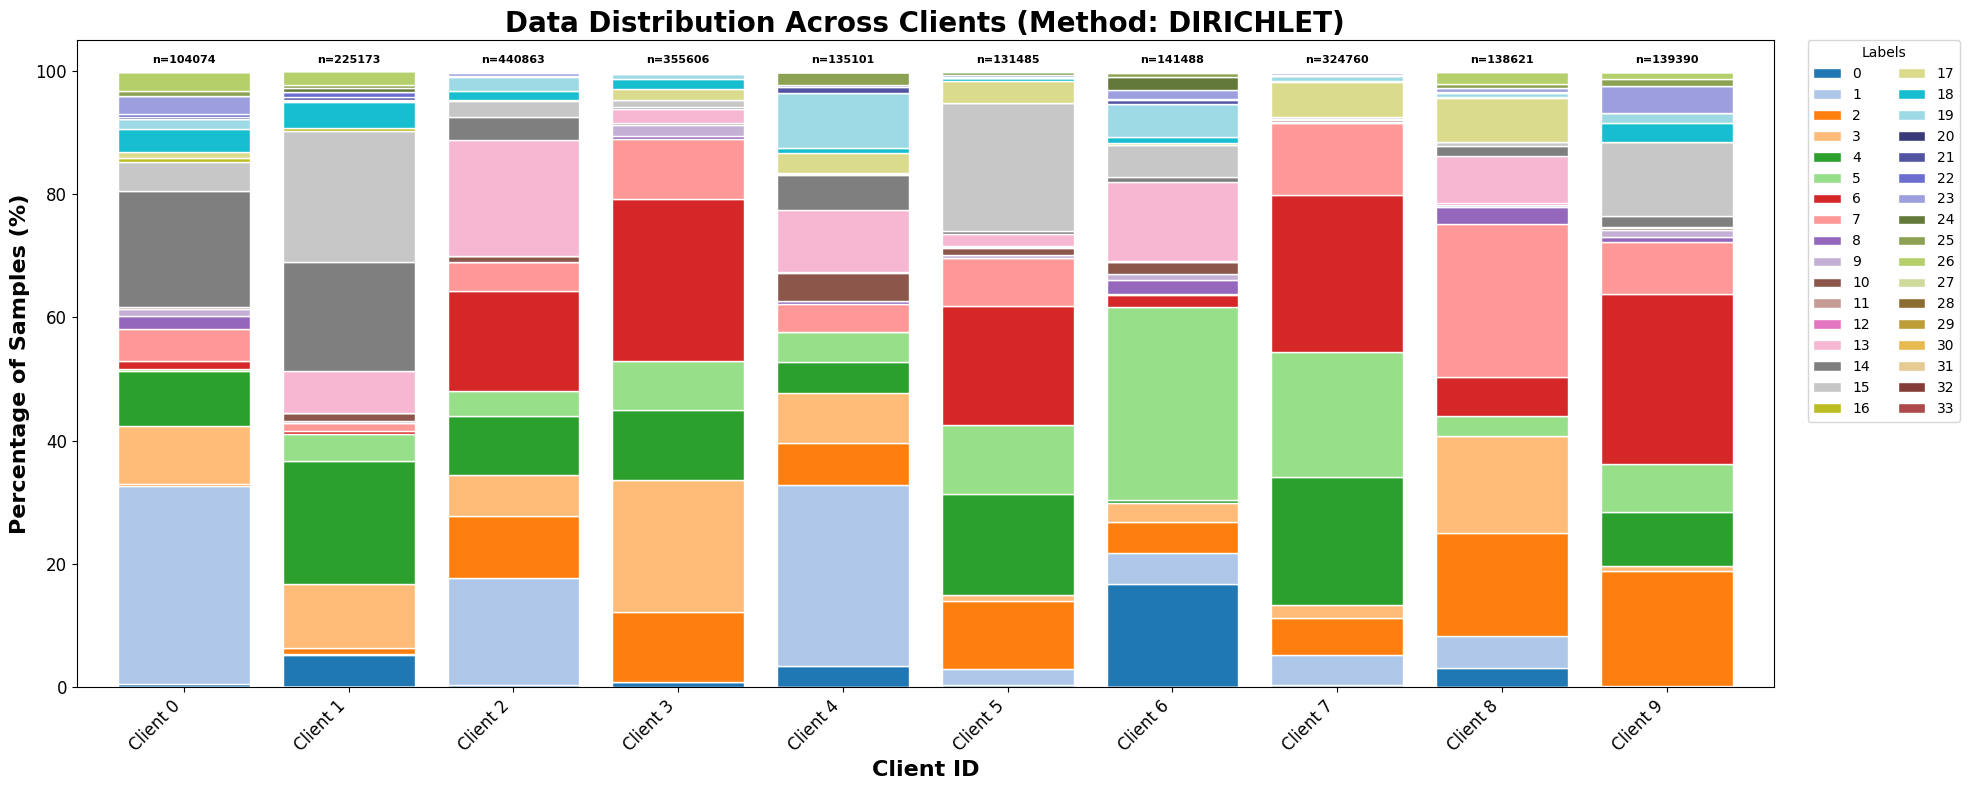

In [31]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [32]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2136603/DIRICHLET_Classifier-34_Clients-10


Convert the training dataset


In [33]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [34]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [35]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 10
NUM_ROUNDS: 5

Original training size: 2136561
Checking training data split groups
0 : X Shape (104074, 39) Y Shape (104074,)
1 : X Shape (225173, 39) Y Shape (225173,)
2 : X Shape (440863, 39) Y Shape (440863,)
3 : X Shape (355606, 39) Y Shape (355606,)
4 : X Shape (135101, 39) Y Shape (135101,)
5 : X Shape (131485, 39) Y Shape (131485,)
6 : X Shape (141488, 39) Y Shape (141488,)
7 : X Shape (324760, 39) Y Shape (324760,)
8 : X Shape (138621, 39) Y Shape (138621,)
9 : X Shape (139390, 39) Y Shape (139390,)

Checking testing data
X_test size: (676597, 39)
y_test size: (676597,)

Deploy Simulation


In [36]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.761867091401996 614.1144156191625 -0.0004547695913776816
Client 0 X min/max/mean: -52.761867091401996 382.1443286224289 0.10989560857392144


#Federated Learning

Import the libraries and print the versions


In [37]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [38]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")

        # Mimic Attack - Model Poisoning Attack (MPA) Implementation
        if self.cid in malicious_client_ids:
            print(f"Client {self.cid} is malicious, applying Mimic Attack (Model Poisoning)...")

            # Phase 1: Normal training (to maintain appearance of benign behavior)
            self.model.fit(self.train_data, self.train_labels, epochs=5, batch_size=32)

            # Phase 2: Mimic Attack - Model Parameter Manipulation
            print(f"Client {self.cid}: Applying model parameter manipulation...")

            # Get the trained model weights
            weights = self.model.get_weights()

            # Apply Mimic Attack: Scale model parameters to inject malicious updates
            # This prevents convergence by injecting scaled malicious parameters
            malicious_weights = []
            for i, layer_weights in enumerate(weights):
                if len(layer_weights.shape) > 1:  # Weight matrices (not biases)
                    # Scale weights to inject malicious updates
                    scaled_weights = layer_weights * mimic_strength
                    malicious_weights.append(scaled_weights)
                else:  # Bias vectors
                    # Scale biases as well
                    scaled_biases = layer_weights * mimic_strength
                    malicious_weights.append(scaled_biases)

            # Set the malicious weights back to the model
            self.model.set_weights(malicious_weights)

            # Phase 3: Additional mimic training for stronger attack
            if mimic_epochs > 0:
                print(f"Client {self.cid}: Additional {mimic_epochs} mimic training epochs...")

                # Create a dataset with all labels as target label for stronger mimicking
                all_target_labels = np.full_like(self.train_labels, mimic_target_label)

                # Compile model with lower learning rate for fine-tuning
                original_optimizer = self.model.optimizer
                self.model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate=mimic_learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )

                # Additional training with target labels to strengthen the attack
                self.model.fit(self.train_data, all_target_labels, epochs=mimic_epochs, batch_size=32, verbose=0)

                # Restore original optimizer
                self.model.compile(
                    optimizer=original_optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )

            print(f"Client {self.cid}: Mimic Attack applied - Model parameters scaled by {mimic_strength}")

        else:
            # Normal training for benign clients
            self.model.fit(self.train_data, self.train_labels, epochs=5, batch_size=32)

        print ("Client ", self.cid, "Training complete...")

        weights = self.model.get_weights()
        return weights, len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.21.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [39]:
from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10, #10,
        min_evaluate_clients=5, #5,
        min_available_clients=10, #10,
        evaluate_fn=get_evaluate_fn(server_model),
        #evaluate_metrics_aggregation_fn=weighted_average,
)
# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = DIRICHLET - Individual (34) Classifier
Number of Clients = 10

Writing output to: train_size-2136603/DIRICHLET_Classifier-34_Clients-10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-09-17 10:10:29,516	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'object_store_memory': 16304947200.0, 'node:172.28.0.12': 1.0, 'memory': 32609894400.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2657) WARNING: All 

(ClientAppActor pid=2657) Client ID: 8
Server Evaluating... Evaluation Count: 0
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.0078 - loss: 3.6148
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


INFO :      initial parameters (loss, other metrics): 3.6142489910125732, {'accuracy': 0.007806715089827776}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Prediction:  [[0.02350824 0.04390244 0.02693756 ... 0.01744024 0.01926801 0.01775526]
 [0.01766279 0.06106617 0.0149346  ... 0.02485031 0.01503415 0.01003388]
 [0.02491465 0.04260377 0.02296264 ... 0.04517741 0.03040914 0.0189622 ]
 ...
 [0.01513323 0.04315009 0.03720493 ... 0.01752064 0.01443031 0.01178306]
 [0.02561503 0.03347884 0.03294088 ... 0.02947277 0.0256434  0.02332774]
 [0.01712941 0.05807354 0.0286922  ... 0.02669162 0.02347448 0.01522272]] (676597, 34)
Server evaluation complete - Accuracy: 0.0078, Loss: 3.6142
(ClientAppActor pid=2657) Client ID: 5
(ClientAppActor pid=2657) Client  5 Training...


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Client ID: 0
(ClientAppActor pid=2657) Epoch 1/5
(ClientAppActor pid=2655) Client 0 is malicious, applying Mimic Attack (Model Poisoning)...


(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  36/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0963 - loss: 3.3967           
 112/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3480 - loss: 2.8749
 182/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4631 - loss: 2.4509
 428/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6170 - loss: 1.7062
(ClientAppActor pid=2655) Client  0 Training...
(ClientAppActor pid=2655) Epoch 1/5
3075/4109 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7864 - loss: 0.7095
(ClientAppActor pid=2655) Epoch 2/5
  34/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7806 - loss: 0.5170    [repeated 2x across cluster]
 102/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8017 - loss: 0.4743 [repeated 92x across cluster]
3253/3253 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7466 - loss: 0.8090 [repeated 4x across cluster]
   1/4109 ━━━━━━━━━━━━━━━━━━━━ 1:50 27ms/step - accuracy: 0.9062 - loss: 0.3017
  69/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8526 - loss: 0.3306
(Clie

(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2657) Epoch 1/5
4109/4109 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8599 - loss: 0.3259 [repeated 2x across cluster]
  33/7037 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.0845 - loss: 3.4828       
  98/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3001 - loss: 3.1131
 164/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3952 - loss: 2.7593
 230/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4507 - loss: 2.4905
 298/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4890 - loss: 2.2824
 366/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5164 - loss: 2.1219
 429/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5359 - loss: 2.0020
 500/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5535 - loss: 1.8913
 572/7037 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5683 - loss: 1.7981
2738/7037 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6886 - loss: 1.0323 [repeated 30x across cluster]
1883/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step 

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Epoch 1/5
5906/7037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7191 - loss: 0.8403
  35/4332 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0536 - loss: 3.4560           
 241/4332 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.4530 - loss: 2.2625 [repeated 51x across cluster]
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7244 - loss: 0.8077
   1/7037 ━━━━━━━━━━━━━━━━━━━━ 3:35 31ms/step - accuracy: 0.8125 - loss: 0.5203
  70/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.7787 - loss: 0.5336
 141/7037 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7737 - loss: 0.5447 
 516/7037 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7720 - loss: 0.5544
(ClientAppActor pid=2657) Epoch 2/5
2602/4332 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7284 - loss: 0.8562
3594/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7440 - loss: 0.7687 [repeated 95x across cluster]
3088/7037 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7715 - loss: 0.5573
(Cli

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/7037 ━━━━━━━━━━━━━━━━━━━━ 3:01 26ms/step - accuracy: 0.8125 - loss: 0.4207
  74/7037 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.7836 - loss: 0.5254
  36/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.1000 - loss: 3.5447    
1185/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7395 - loss: 1.2237 [repeated 81x across cluster]
 980/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7189 - loss: 1.3346 [repeated 2x across cluster]
(ClientAppActor pid=2657) Epoch 5/5
(ClientAppActor pid=2655) Epoch 2/5
   1/4422 ━━━━━━━━━━━━━━━━━━━━ 1:56 26ms/step - accuracy: 0.9062 - loss: 0.2706
  69/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8863 - loss: 0.3510
 139/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8878 - loss: 0.3525 [repeated 96x across cluster]
5811/7037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7767 - loss: 0.5351 [repeated 5x across cluster]
(ClientAppActor pid=2657) Client 1: Applying model parameter manipulation...
(ClientAppActor pid=2657) Clie

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  34/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0499 - loss: 3.4421           
1955/4356 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7796 - loss: 0.8442 [repeated 37x across cluster]
3488/4356 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8155 - loss: 0.6503
(ClientAppActor pid=2655) Epoch 2/5
  36/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8871 - loss: 0.2765   
(ClientAppActor pid=2657) Client 1: Mimic Attack applied - Model parameters scaled by 2.0
(ClientAppActor pid=2657) Client  1 Training complete...
 414/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8938 - loss: 0.2580
 449/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8935 - loss: 0.2584
(ClientAppActor pid=2657) Client ID: 4
(ClientAppActor pid=2657) Client  4 Training...
(ClientAppActor pid=2657) Client 4 is malicious, applying Mimic Attack (Model Poisoning)...
 485/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8932 - loss: 0.2587


(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 930/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8915 - loss: 0.2607 [repeated 47x across cluster]
   1/4222 ━━━━━━━━━━━━━━━━━━━━ 1:29:40 1s/step - accuracy: 0.0312 - loss: 3.8986
  65/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.2933 - loss: 3.0057
1146/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6814 - loss: 1.1484
(ClientAppActor pid=2657) Epoch 1/5
(ClientAppActor pid=2655) Epoch 3/5
4356/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8906 - loss: 0.2627 [repeated 89x across cluster]
  72/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8925 - loss: 0.2940
   1/4356 ━━━━━━━━━━━━━━━━━━━━ 1:58 27ms/step - accuracy: 0.8125 - loss: 0.5427
   1/4222 ━━━━━━━━━━━━━━━━━━━━ 1:55 27ms/step - accuracy: 0.8438 - loss: 0.3383
1498/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8942 - loss: 0.2533 [repeated 4x across cluster]
(ClientAppActor pid=2657) Epoch 2/5
3355/4356 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8936 - loss: 0.2522 [repeated 95x across cl

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Epoch 1/5
3632/4222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8301 - loss: 0.3564 [repeated 93x across cluster]
4222/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8301 - loss: 0.3566
   35/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.1620 - loss: 3.4045          
  102/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.4500 - loss: 2.8849
  168/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5776 - loss: 2.4003
  238/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6527 - loss: 2.0441
  308/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7006 - loss: 1.7933
  378/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7343 - loss: 1.6067
  445/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7586 - loss: 1.4678
  514/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7783 - loss: 1.3524
  584/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7944 - loss: 1.2566
  656/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - ac

(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 7449/10149 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9678 - loss: 0.1068
 7525/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9678 - loss: 0.1068
(ClientAppActor pid=2657) Epoch 1/5
 7600/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9678 - loss: 0.1068
 7676/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9678 - loss: 0.1068
 7754/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9678 - loss: 0.1067
 7827/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9678 - loss: 0.1067
 7895/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9678 - loss: 0.1067
 7971/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9678 - loss: 0.1067
 8046/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9678 - loss: 0.1066
 8121/10149 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9678 - loss: 0.1066
 8196/10149 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9678 - loss: 0.1066
 8269/10149 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9678 - loss: 0.1066
    1/11113 ━━━━

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Epoch 1/5
10393/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8538 - loss: 0.3236 [repeated 3x across cluster]
    1/13777 ━━━━━━━━━━━━━━━━━━━━ 3:50:59 1s/step - accuracy: 0.0000e+00 - loss: 3.6541
   36/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8471 - loss: 0.3343  
   64/13777 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.3109 - loss: 3.0405
  100/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8545 - loss: 0.3222
  830/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6627 - loss: 1.2703
11040/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8538 - loss: 0.3237 [repeated 32x across cluster]
 2206/11113 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8554 - loss: 0.3196
(ClientAppActor pid=2657) Epoch 4/5
11113/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.8538 - loss: 0.3237 [repeated 2x across cluster]
 3431/13777 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7522 - loss: 0.7156 [repeated 96x across cluster]
 36

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=2655) Client 2: Mimic Attack applied - Model parameters scaled by 2.0
(ClientAppActor pid=2655) Client  2 Training complete...
Server Evaluating... Evaluation Count: 1
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.2435 - loss: 5.2067
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


INFO :      fit progress: (1, 5.191365718841553, {'accuracy': 0.24425765872001648}, 440.70556643200007)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[9.93196487e-01 1.20529986e-09 1.24773169e-06 ... 7.18106961e-08
  8.47122180e-07 1.41104247e-05]
 [9.99827981e-01 1.85898109e-16 2.37411029e-13 ... 4.72216430e-14
  1.78716920e-11 4.59738070e-09]
 [8.70755851e-01 9.11980820e-08 1.50332911e-04 ... 1.19113865e-05
  2.93369172e-04 2.93403165e-04]
 ...
 [9.99999881e-01 2.19795556e-25 4.09929101e-19 ... 1.95246916e-21
  9.79236675e-18 9.69018715e-16]
 [4.68936996e-05 1.92850229e-20 1.21669316e-15 ... 1.87584176e-33
  2.14718972e-31 4.05033627e-23]
 [9.35410739e-14 1.00000000e+00 2.56892375e-34 ... 0.00000000e+00
  0.00000000e+00 7.80523245e-43]] (676597, 34)
Server evaluation complete - Accuracy: 0.2443, Loss: 5.1914


(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Client ID: 6
(ClientAppActor pid=2655) Client  6 Evaluating...


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/4422 ━━━━━━━━━━━━━━━━━━━━ 16:42 227ms/step - accuracy: 1.0000 - loss: 2.3997e-05
  95/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 2.5244e-05
 181/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 2.4912e-05
  43/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9900 - loss: 0.1222         
  86/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9881 - loss: 0.0983
 266/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 2.4857e-05
 171/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9866 - loss: 0.0835
 351/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 2.4854e-05
 257/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9858 - loss: 0.0806
 437/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 2.4894e-05
 342/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9852 - loss: 0.0800
 525/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 2.4966e-05
 430/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Client  1 Evaluating...


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   1/7037 ━━━━━━━━━━━━━━━━━━━━ 34:00 290ms/step - accuracy: 1.0000 - loss: 3.1312e-05
  85/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 1.0000 - loss: 2.7922e-05
 175/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 1.0000 - loss: 2.8040e-05
 263/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 1.0000 - loss: 2.8219e-05
  44/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 2.8791e-05     
 347/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 1.0000 - loss: 2.8370e-05
 213/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9999 - loss: 0.0045
 854/4222 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9996 - loss: 0.0146
3602/7037 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3876 - loss: 2.7637 [repeated 73x across cluster]
1073/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7793 - loss: 1.1284 [repeated 2x across cluster]
(ClientAppActor pid=2657) Client 9 evaluation complete - Accuracy: 0.241796, Loss: 5.950332
(ClientAppActor pid=2657) Client ID: 4
(Clien

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

    1/11113 ━━━━━━━━━━━━━━━━━━━━ 49:42 268ms/step - accuracy: 1.0000 - loss: 9.9648e-06
   82/11113 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 1.0000 - loss: 2.5969e-05
  165/11113 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9980 - loss: 0.0136
  251/11113 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9961 - loss: 0.0264
  338/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9947 - loss: 0.0333
  425/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9938 - loss: 0.0380
  512/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9930 - loss: 0.0429
  597/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9923 - loss: 0.0473
  683/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9918 - loss: 0.0508
  768/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9913 - loss: 0.0535
  851/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9909 - loss: 0.0555
  934/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9906 - loss: 0.0572
 1018/11113 ━━━━━━━━━━━━━━━━

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


11049/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3858 - loss: 3.2985
11113/11113 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.3845 - loss: 3.3134
(ClientAppActor pid=2657) Client 3 evaluation complete - Accuracy: 0.160678, Loss: 5.873727
(ClientAppActor pid=2657) Client ID: 8
(ClientAppActor pid=2657) Client  8 Training...
(ClientAppActor pid=2655) Client 4 is malicious, applying Mimic Attack (Model Poisoning)...
(ClientAppActor pid=2657) Epoch 1/5


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/4332 ━━━━━━━━━━━━━━━━━━━━ 54:42 758ms/step - accuracy: 0.3125 - loss: 5.6711
  75/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4928 - loss: 3.3552
  35/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6027 - loss: 2.7221     
 144/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5765 - loss: 2.5271
2271/4222 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7979 - loss: 0.6286
(ClientAppActor pid=2655) Client ID: 4
(ClientAppActor pid=2655) Client  4 Training...
(ClientAppActor pid=2655) Epoch 1/5
3401/4222 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8057 - loss: 0.5630 [repeated 96x across cluster]
(ClientAppActor pid=2655) Epoch 2/5
   1/4222 ━━━━━━━━━━━━━━━━━━━━ 1:50 26ms/step - accuracy: 0.9062 - loss: 0.2555
  67/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8310 - loss: 0.3803
  33/4332 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8226 - loss: 0.3780   
1105/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8305 - loss: 0.3670 [repeated 5x across clust

(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=2657)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=2657) Epoch 1/5
  32/4422 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4856 - loss: 3.7949    
4222/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8368 - loss: 0.3496 [repeated 3x across cluster]
1028/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8312 - loss: 0.8803 [repeated 48x across cluster]
 682/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8120 - loss: 1.0510
4391/4422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8684 - loss: 0.5369 [repeated 49x across cluster]
4422/4422 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8685 - loss: 0.5359
(ClientAppActor pid=2657) Epoch 2/5
  35/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8953 - loss: 0.3159   
3332/4422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8892 - loss: 0.3428 [repeated 48x across cluster]
3882/4422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8892 - loss: 0.3427
(ClientAppActor pid=2657) Epoch 3/5
   1/4422 ━━━━━━━━━━━━━━━━━━━━ 2:03 28ms/step - accuracy: 0.8750 - loss: 

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=2655) Epoch 1/5
  33/4109 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3892 - loss: 3.0410       
4252/4422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8891 - loss: 0.3346
4422/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8891 - loss: 0.3346
(ClientAppActor pid=2657) Epoch 4/5
   1/4422 ━━━━━━━━━━━━━━━━━━━━ 1:46 24ms/step - accuracy: 0.8750 - loss: 0.3997
  73/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8930 - loss: 0.3190
2007/4109 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8115 - loss: 0.6048 [repeated 73x across cluster]
4109/4109 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8293 - loss: 0.4931
  33/4109 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8762 - loss: 0.3167   
1938/4422 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8906 - loss: 0.3321 [repeated 2x across cluster]
(ClientAppActor pid=2655) Epoch 2/5
(ClientAppActor pid=2657) Epoch 5/5
   1/4422 ━━━━━━━━━━━━━━━━━━━━ 1:52 25ms/step - accuracy: 1.0000 - loss: 0.1027
  66/4422 ━

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

    1/10149 ━━━━━━━━━━━━━━━━━━━━ 2:45:53 981ms/step - accuracy: 0.1250 - loss: 6.1930
   68/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5811 - loss: 2.4541
  139/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7113 - loss: 1.7176
  208/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7699 - loss: 1.3736
  278/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8051 - loss: 1.1622
  347/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8284 - loss: 1.0190
4422/4422 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8916 - loss: 0.3266 [repeated 3x across cluster]
  415/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8450 - loss: 0.9160
  485/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8580 - loss: 0.8345
  555/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8683 - loss: 0.7700
  658/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.8801 - loss: 0.6958
  728/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.8864 - loss: 0.6553
  797/10

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

  178/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9685 - loss: 0.1036
  248/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9692 - loss: 0.1024
  322/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9694 - loss: 0.1027
  397/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9694 - loss: 0.1030
  473/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9692 - loss: 0.1037
  550/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9691 - loss: 0.1040
  624/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9691 - loss: 0.1042
  698/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9690 - loss: 0.1043
  774/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9689 - loss: 0.1043
   1/7037 ━━━━━━━━━━━━━━━━━━━━ 1:53:48 971ms/step - accuracy: 0.1250 - loss: 4.1656
  852/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9688 - loss: 0.1044
  890/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9688 - loss: 0.1045
  68/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2657) Client  0 Training...
(ClientAppActor pid=2657) Client 0 is malicious, applying Mimic Attack (Model Poisoning)...
(ClientAppActor pid=2657) Epoch 1/5
   1/3253 ━━━━━━━━━━━━━━━━━━━━ 53:12 982ms/step - accuracy: 0.4375 - loss: 6.8054
  69/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4871 - loss: 3.5356
1086/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7240 - loss: 1.1037
1050/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7219 - loss: 1.1190 [repeated 14x across cluster]
(ClientAppActor pid=2657) Epoch 2/5
  37/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8299 - loss: 0.4220   
 357/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8245 - loss: 0.4397
 393/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8242 - loss: 0.4401
 429/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8239 - loss: 0.4406
1284/3253 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8225 - loss: 0.4414 [repeated 47x across cluster]
(ClientAppActor pid=2657) E

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Epoch 1/5
3253/3253 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8253 - loss: 0.4202
(ClientAppActor pid=2657) Client 0: Applying model parameter manipulation...
(ClientAppActor pid=2657) Client 0: Additional 3 mimic training epochs...
    1/11113 ━━━━━━━━━━━━━━━━━━━━ 2:39:30 861ms/step - accuracy: 0.0938 - loss: 4.9920
   70/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.4984 - loss: 2.6442
  138/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.6056 - loss: 1.9330
  205/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.6605 - loss: 1.5881
  273/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.6936 - loss: 1.3759
  342/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.7159 - loss: 1.2308
  412/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7321 - loss: 1.1242
  480/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7439 - loss: 1.0452
  549/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.7532 - loss: 0.9815
  617/1111

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 9978/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8417 - loss: 0.3992
(ClientAppActor pid=2657) Client  9 Training...
(ClientAppActor pid=2657) Epoch 1/5
10055/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8418 - loss: 0.3987
10166/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8419 - loss: 0.3981
10242/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8420 - loss: 0.3976
10320/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8420 - loss: 0.3972
10396/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8421 - loss: 0.3968
10474/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8422 - loss: 0.3964
10550/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8422 - loss: 0.3959
10625/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8423 - loss: 0.3955
10702/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.3951
10775/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8424 - loss: 0.3947
  34/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - ac

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

10691/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8613 - loss: 0.3098
(ClientAppActor pid=2657) Client  2 Training...
(ClientAppActor pid=2657) Client 2 is malicious, applying Mimic Attack (Model Poisoning)...
10764/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8613 - loss: 0.3098
10838/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8612 - loss: 0.3098
(ClientAppActor pid=2657) Epoch 1/5
10913/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8612 - loss: 0.3098
10991/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8612 - loss: 0.3099
11067/11113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8612 - loss: 0.3099
11113/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.8612 - loss: 0.3099
    1/11113 ━━━━━━━━━━━━━━━━━━━━ 5:07 28ms/step - accuracy: 0.8750 - loss: 0.2102
   75/11113 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8815 - loss: 0.2866
  153/11113 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8743 - loss: 0.2969
  230/11113 ━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 10 results and 0 failures


Server Evaluating... Evaluation Count: 2
(ClientAppActor pid=2657) Client 2: Mimic Attack applied - Model parameters scaled by 2.0
(ClientAppActor pid=2657) Client  2 Training complete...
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.0260 - loss: 65.5348
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


INFO :      fit progress: (2, 65.60350036621094, {'accuracy': 0.02575092762708664}, 908.4570300050001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[1.00000000e+00 2.90756820e-40 4.79007050e-27 ... 9.05050095e-22
  6.33358813e-23 1.83057008e-19]
 [1.00000000e+00 0.00000000e+00 3.34346809e-37 ... 1.36136063e-27
  1.70049368e-29 3.30987379e-24]
 [9.99990463e-01 9.71042611e-28 2.86317253e-17 ... 5.50580733e-14
  1.79277657e-14 2.69978267e-12]
 ...
 [9.99947548e-01 0.00000000e+00 0.00000000e+00 ... 1.15379225e-11
  2.23365196e-33 3.75550521e-25]
 [1.00000000e+00 6.42200008e-38 4.45931474e-30 ... 2.94869560e-24
  5.61865178e-33 1.20855378e-19]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] (676597, 34)
Server evaluation complete - Accuracy: 0.0258, Loss: 65.6035


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=2657) Client ID: 3
(ClientAppActor pid=2657) Client  3 Evaluating...


(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         


   1/4422 ━━━━━━━━━━━━━━━━━━━━ 17:22 236ms/step - accuracy: 1.0000 - loss: 1.1176e-08
   44/11113 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 1.0000 - loss: 1.8654e-07    
  80/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 2.4011e-07
  123/11113 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9377 - loss: 10.1307   
 162/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 2.7036e-07
 816/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9955 - loss: 1.0587
 897/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9837 - loss: 3.8535
 979/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9675 - loss: 7.6911
 1063/11113 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.2761 - loss: 96.6637
1061/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9488 - loss: 11.6491
1145/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9285 - loss: 15.5159
1225/4422 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9086 - loss: 18.9516
 1313/11113 ━━━━━━━━━━━━━━━━━━━━ 1

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=2655)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

 4799/11113 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0916 - loss: 85.1417
 4882/11113 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0905 - loss: 84.7152
   1/4109 ━━━━━━━━━━━━━━━━━━━━ 18:34 271ms/step - accuracy: 1.0000 - loss: 8.5681e-07
 4969/11113 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0893 - loss: 84.2771
  81/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4353 - loss: 133.7048
 5050/11113 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0882 - loss: 83.8763
 166/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2658 - loss: 168.9694
 5135/11113 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0872 - loss: 83.4604
 247/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1986 - loss: 171.9196
 5218/11113 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0861 - loss: 83.0588
 332/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1589 - loss: 169.9682
 5303/11113 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0851 - loss: 82.6522
 413/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 9369/11113 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0558 - loss: 70.3221
 9457/11113 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0555 - loss: 70.1569
 9546/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0551 - loss: 69.9912
  43/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 1.0000 - loss: 1.5740e-07     
 9633/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0547 - loss: 69.8305
 126/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 1.0000 - loss: 2.3626e-07
 9716/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0543 - loss: 69.6785
 208/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 1.0000 - loss: 2.4973e-07
 9796/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0540 - loss: 69.5330
 293/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 1.0000 - loss: 2.4521e-07
 9881/11113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0537 - loss: 69.3797
 375/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9993 - loss: 0.1653    
 9964/11113 ━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

1849/7037 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5188 - loss: 24.6358
1939/7037 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5038 - loss: 25.0889
2027/7037 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4901 - loss: 25.5028
   1/4356 ━━━━━━━━━━━━━━━━━━━━ 20:00 276ms/step - accuracy: 0.2188 - loss: 188.5939
2108/7037 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4781 - loss: 25.8610
  81/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0135 - loss: 158.1887
2194/7037 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4661 - loss: 26.2194
 167/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0076 - loss: 147.1438
2280/7037 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4548 - loss: 26.5571
 252/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.0055 - loss: 142.8786
2363/7037 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4444 - loss: 26.8654
 335/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.0044 - loss: 140.5986
2448/7037 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy:

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2655) Client ID: 9
(ClientAppActor pid=2655) Client  9 Training...
(ClientAppActor pid=2655) Epoch 1/5


(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  36/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0767 - loss: 45.0626     
   1/4332 ━━━━━━━━━━━━━━━━━━━━ 58:26 810ms/step - accuracy: 0.0312 - loss: 62.8984
  69/4332 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0877 - loss: 42.2636
 798/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6148 - loss: 9.1855
 867/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6280 - loss: 8.6752
 939/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6403 - loss: 8.2083
1005/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6504 - loss: 7.8287
1074/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6600 - loss: 7.4731
(ClientAppActor pid=2655) Client 1 evaluation complete - Accuracy: 0.053208, Loss: 37.385876
2174/4332 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6688 - loss: 5.2969
 906/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5655 - loss: 9.7895  [repeated 26x across cluster]
(ClientAppActor pid=2657) Client ID: 8
(ClientAppActor pid=2657) Client  8 Training...
(Clien

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2657) Epoch 1/5


(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


   38/13777 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.0407 - loss: 67.6590          
    1/11113 ━━━━━━━━━━━━━━━━━━━━ 2:29:07 805ms/step - accuracy: 0.0312 - loss: 61.9472
  110/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.1769 - loss: 45.2835
   68/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.1448 - loss: 33.8389
  179/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.2830 - loss: 34.6944
4356/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8942 - loss: 0.2556 [repeated 2x across cluster]
  302/11113 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.4074 - loss: 15.9019
  704/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5722 - loss: 9.1220
  774/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5877 - loss: 8.5477
  841/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6006 - loss: 8.0721
  905/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6115 - loss: 7.6725
  972/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6218 - loss:

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Epoch 1/5
   1/3253 ━━━━━━━━━━━━━━━━━━━━ 53:47 993ms/step - accuracy: 0.0312 - loss: 116.3373
  68/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0381 - loss: 73.1561
 137/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1311 - loss: 52.3040
 169/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1676 - loss: 46.5045
 238/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2373 - loss: 37.8958
 307/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2929 - loss: 32.2789
 369/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3326 - loss: 28.6421
 438/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3683 - loss: 25.5612
 506/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3975 - loss: 23.1890
 574/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4224 - loss: 21.2717
 643/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4442 - loss: 19.6646
 713/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4634 - loss: 18.2961
 782/3253 ━━━━━━━━━━━━

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2657) Client  1 Training...
(ClientAppActor pid=2657) Client 1 is malicious, applying Mimic Attack (Model Poisoning)...
(ClientAppActor pid=2657) Epoch 1/5
  34/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.0659 - loss: 33.3409   
 101/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.0926 - loss: 25.2005
 166/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.1664 - loss: 20.2215
 232/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2346 - loss: 16.9927
 297/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2891 - loss: 14.7950
 363/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3336 - loss: 13.1524
 430/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3698 - loss: 11.8727
 496/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3996 - loss: 10.8703
 562/7037 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.4248 - loss: 10.0502 
 629/7037 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.4467 - loss: 9.3562
 702/7037 ━━━━━━━━━━━━━━━━━━━━ 9s

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Epoch 1/5
5914/7037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6988 - loss: 2.2059
5986/7037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6994 - loss: 2.1901
6062/7037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7000 - loss: 2.1737
6140/7037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7007 - loss: 2.1573
6218/7037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7013 - loss: 2.1413
6294/7037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7019 - loss: 2.1260
6370/7037 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7025 - loss: 2.1110
6446/7037 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7031 - loss: 2.0964
6523/7037 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7037 - loss: 2.0818
6599/7037 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7043 - loss: 2.0678
  33/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1898 - loss: 37.3543       
6668/7037 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7048 - loss: 2.0553
 100/4422 ━━━━━━━━━━━━━━━━━━━━ 6

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  71/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0961 - loss: 68.6918
3217/7037 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7747 - loss: 0.5394
4422/4422 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8887 - loss: 0.3356 [repeated 2x across cluster]
1860/4222 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6968 - loss: 8.4324 [repeated 57x across cluster]
(ClientAppActor pid=2655) Epoch 1/5
  35/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0342 - loss: 86.7259         
1507/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6756 - loss: 9.8548  [repeated 21x across cluster]
(ClientAppActor pid=2655) Epoch 2/5
   1/4222 ━━━━━━━━━━━━━━━━━━━━ 1:52 27ms/step - accuracy: 0.8750 - loss: 0.3224
  36/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8429 - loss: 0.3998   
4222/4222 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7564 - loss: 4.5827 [repeated 5x across cluster]
1086/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8292 - loss: 0.3809 [repeated 96x across c

(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  36/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0476 - loss: 43.4051           
 105/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.1568 - loss: 30.2793
 172/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2544 - loss: 23.6373
 241/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3346 - loss: 19.5215
 313/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3978 - loss: 16.6568
 381/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4434 - loss: 14.7112
 451/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4806 - loss: 13.1895
 520/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5104 - loss: 12.0062
 591/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5360 - loss: 11.0190
 660/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5569 - loss: 10.2240
 731/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5753 - loss: 9.5340
 834/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5976 - loss: 8.7056
2650/4109 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

3134/4109 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8562 - loss: 0.3413
  101/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.1916 - loss: 30.7651
  171/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.3107 - loss: 23.5346
(ClientAppActor pid=2655) Epoch 1/5
   34/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.0588 - loss: 44.0394       
  241/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.4051 - loss: 19.2631
  309/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.4730 - loss: 16.5053
  378/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.5255 - loss: 14.4918
  445/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.5658 - loss: 13.0104
  512/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.5985 - loss: 11.8386
  582/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6268 - loss: 10.8450
  651/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6502 - loss: 10.0344
  719/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.6699 - los

INFO :      aggregate_fit: received 10 results and 0 failures


10064/10149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9684 - loss: 0.1020
10138/10149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9684 - loss: 0.1020
Server Evaluating... Evaluation Count: 3
10149/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9684 - loss: 0.1020
(ClientAppActor pid=2655) Client  7 Training complete...
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.0247 - loss: 143.8238
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


INFO :      fit progress: (3, 143.81356811523438, {'accuracy': 0.024346841499209404}, 1361.079980864)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[1.0000000e+00 0.0000000e+00 1.9510904e-30 ... 0.0000000e+00
  2.7459967e-36 1.0156374e-26]
 [1.0000000e+00 0.0000000e+00 1.5414283e-44 ... 0.0000000e+00
  0.0000000e+00 9.7314881e-39]
 [1.0000000e+00 0.0000000e+00 1.4355380e-34 ... 0.0000000e+00
  1.9783718e-37 1.2603736e-28]
 ...
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.7615186e-31
  0.0000000e+00 1.0229479e-42]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]] (676597, 34)
Server evaluation complete - Accuracy: 0.0243, Loss: 143.8136


(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Client ID: 5
(ClientAppActor pid=2655) Client  5 Evaluating...


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  42/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6471 - loss: 101.0517       
 124/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3267 - loss: 192.7607
   1/4422 ━━━━━━━━━━━━━━━━━━━━ 19:09 260ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 205/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2282 - loss: 221.3331
  82/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 5.7457e-08
 284/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1793 - loss: 235.5740
 161/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 5.1384e-08
 366/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1480 - loss: 244.7545
 243/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 4.8906e-08
 449/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1266 - loss: 251.0556
 323/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 4.6274e-08
 531/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.1112 - loss: 255.5850
 406/4422 ━━━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

4328/4422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4756 - loss: 79.1831
4411/4422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4699 - loss: 79.7883
  33/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0000 - loss: 4.4727e-08     
4422/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.4691 - loss: 79.8726
 105/4222 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 1.0000 - loss: 4.6457e-08


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 188/4222 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9701 - loss: 8.5198
 272/4222 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8661 - loss: 38.2853
 597/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5845 - loss: 119.1783
 520/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6327 - loss: 105.3296 [repeated 3x across cluster]
 682/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5398 - loss: 132.0011
  124/13777 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.7675 - loss: 66.2620
 766/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5025 - loss: 142.7075
 849/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4708 - loss: 151.7771
  291/13777 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.4734 - loss: 150.6832
 935/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4424 - loss: 159.9149
  377/13777 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.3997 - loss: 171.8273
1019/4222 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4181 - loss: 166.8711
  461/13777 ━━━━━━

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 3942/13777 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0682 - loss: 267.0994
 4027/13777 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0670 - loss: 267.2332
 4112/13777 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0659 - loss: 267.2658
 4197/13777 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0648 - loss: 267.2068
   41/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.8878 - loss: 32.0891       
 4279/13777 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0638 - loss: 267.0716
  123/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.5048 - loss: 141.7987
 4359/13777 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0629 - loss: 266.8724
  205/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.3614 - loss: 182.8012
 4440/13777 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0619 - loss: 266.6094
 5559/13777 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0516 - loss: 259.3651
 4893/13777 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.0572 - loss: 264.2589 [repeated 2

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=2655) Client ID: 2
(ClientAppActor pid=2655) Client  2 Training...
(ClientAppActor pid=2655) Client 2 is malicious, applying Mimic Attack (Model Poisoning)...


(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Epoch 1/5
    1/13777 ━━━━━━━━━━━━━━━━━━━━ 3:05:44 809ms/step - accuracy: 0.0000e+00 - loss: 184.7790
   73/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.0434 - loss: 128.0977
  139/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.1459 - loss: 97.2829 
   34/11113 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.0129 - loss: 124.3683          
  483/11113 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.3768 - loss: 40.2115
 1104/13777 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.5670 - loss: 26.4683 [repeated 62x across cluster]
 9442/10149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0191 - loss: 164.4009
(ClientAppActor pid=2655) Client 7 evaluation complete - Accuracy: 0.004225, Loss: 145.601395
(ClientAppActor pid=2657) Client ID: 3
(ClientAppActor pid=2657) Client  3 Training...
(ClientAppActor pid=2657) Client 3 is malicious, applying Mimic Attack (Model Poisoning)...
(ClientAppActor pid=2657) Epoch 1/5
 3385/11113 ━━━━━━━━━━━━━━━━━━━━ 1

(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=2657)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=2657) Client  8 Training...
(ClientAppActor pid=2657) Epoch 1/5
   1/4332 ━━━━━━━━━━━━━━━━━━━━ 1:11:44 994ms/step - accuracy: 0.0312 - loss: 130.1793
  69/4332 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0436 - loss: 105.0747
 136/4332 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.1025 - loss: 81.5660
 204/4332 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.1545 - loss: 67.3200
 275/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.1991 - loss: 57.4305
 345/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2388 - loss: 50.4713
 415/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2747 - loss: 45.2017
 484/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3059 - loss: 41.1135
 554/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3340 - loss: 37.7513
 623/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3582 - loss: 35.0067
 692/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3796 - loss: 32.6857
 762/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accu

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

2713/4332 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8093 - loss: 0.4296
2787/4332 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8093 - loss: 0.4297
2861/4332 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8093 - loss: 0.4297
2936/4332 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8093 - loss: 0.4297
3012/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.4297
3085/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.4298
3162/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.4298
3236/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.4298
3312/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.4299
3385/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.4299
3461/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.4299
(ClientAppActor pid=2655) Epoch 1/5
3535/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8093 - loss: 0.4299
3608/4332 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 764/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4256 - loss: 32.1545
(ClientAppActor pid=2657) Epoch 1/5
 838/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4425 - loss: 30.2240
 908/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4568 - loss: 28.6279
 982/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4704 - loss: 27.1386
1056/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4826 - loss: 25.8183
1130/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4937 - loss: 24.6380
1200/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5032 - loss: 23.6303
1267/3253 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5117 - loss: 22.7509
1333/3253 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5195 - loss: 21.9553
1394/3253 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5261 - loss: 21.2750
1453/3253 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5322 - loss: 20.6617
   1/4222 ━━━━━━━━━━━━━━━━━━━━ 1:13:14 1s/step - accuracy: 0.0000e+00 - loss: 205.0157
1513/3253 ━━━━━━━━━

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Client  5 Training...
(ClientAppActor pid=2655) Epoch 1/5
   1/4109 ━━━━━━━━━━━━━━━━━━━━ 1:06:23 970ms/step - accuracy: 0.0000e+00 - loss: 126.3006
  69/4109 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0507 - loss: 106.4545
 140/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.1384 - loss: 81.0981
 208/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2224 - loss: 66.3267
 277/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2898 - loss: 56.4705
 343/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3402 - loss: 49.7454
 412/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3820 - loss: 44.4257
 480/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4152 - loss: 40.3201
 550/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4440 - loss: 36.9093
 618/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4680 - loss: 34.1742
 686/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4890 - loss: 31.8655
 756/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - 

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

4109/4109 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8553 - loss: 0.3657
(ClientAppActor pid=2655) Epoch 3/5
  38/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8306 - loss: 0.3606   
 112/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8423 - loss: 0.3482
 189/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8473 - loss: 0.3441
 264/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8487 - loss: 0.3435
 337/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8492 - loss: 0.3438
 409/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8498 - loss: 0.3438
 485/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8502 - loss: 0.3437
 560/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8504 - loss: 0.3442
 633/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8507 - loss: 0.3442
 706/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8510 - loss: 0.3441
 782/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8514 - loss: 0.3440
 856/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=2655) Epoch 1/5
   35/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.0072 - loss: 119.1148       
  106/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.1188 - loss: 85.4913
  176/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.2098 - loss: 67.8148
  243/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.2846 - loss: 57.0650
  315/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.3491 - loss: 49.1365
  385/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.3989 - loss: 43.5172
  454/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.4397 - loss: 39.2504
  523/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.4747 - loss: 35.8375
  593/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.5055 - loss: 33.0008
  661/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.5315 - loss: 30.6944
  732/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.5555 - loss: 28.6451
  801/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.5761 

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 4260/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9680 - loss: 0.1027
(ClientAppActor pid=2657) Epoch 1/5
 4325/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9680 - loss: 0.1027
 4394/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9680 - loss: 0.1026
 4466/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9680 - loss: 0.1026
 4536/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9680 - loss: 0.1026
 4604/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9680 - loss: 0.1026
 4672/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9680 - loss: 0.1026
 4739/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9681 - loss: 0.1027
 4811/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9681 - loss: 0.1027
 4887/10149 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9681 - loss: 0.1028
 4963/10149 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9681 - loss: 0.1028
   1/4356 ━━━━━━━━━━━━━━━━━━━━ 1:13:53 1s/step - accuracy: 0.0000e+00 - loss: 179.8449
 5030/10

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

1019/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8869 - loss: 0.3298
1090/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8870 - loss: 0.3291
1164/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8872 - loss: 0.3284
1238/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8873 - loss: 0.3277
1312/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8874 - loss: 0.3270
1385/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8874 - loss: 0.3263
1460/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8875 - loss: 0.3257
1533/4356 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8876 - loss: 0.3250
1610/4356 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8876 - loss: 0.3244
   1/4422 ━━━━━━━━━━━━━━━━━━━━ 1:11:54 976ms/step - accuracy: 0.1250 - loss: 84.6605
1682/4356 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8877 - loss: 0.3239
  66/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1770 - loss: 87.1971
1749/4356 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8877 - los

INFO :      aggregate_fit: received 10 results and 0 failures


Server Evaluating... Evaluation Count: 4
(ClientAppActor pid=2655) Client  6 Training complete...
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.0237 - loss: 390.2643
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


INFO :      fit progress: (4, 390.087646484375, {'accuracy': 0.023341812193393707}, 1801.2457928620001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]] (676597, 34)
Server evaluation complete - Accuracy: 0.0233, Loss: 390.0876


(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Client ID: 4
(ClientAppActor pid=2655) Client  4 Evaluating...
4422/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8877 - loss: 0.3559 [repeated 44x across cluster]


(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  48/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00     
 136/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 220/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9319 - loss: 48.5440
 128/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3196 - loss: 487.0768
 306/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8254 - loss: 124.8234
 214/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2209 - loss: 575.4512
1972/4222 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2644 - loss: 524.7892
2723/4109 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0290 - loss: 525.5615
(ClientAppActor pid=2657) Client ID: 5
(ClientAppActor pid=2657) Client  5 Evaluating...
4222/4222 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.1495 - loss: 518.9493
(ClientAppActor pid=2655) Client 4 evaluation complete - Accuracy: 0.034219, Loss: 496.392639
  44/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6307 - loss: 263.4462       
(ClientAppAc

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=2655)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

4076/4109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0206 - loss: 491.6580 [repeated 89x across cluster]


(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  43/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00     
 127/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
   1/7037 ━━━━━━━━━━━━━━━━━━━━ 30:22 259ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 210/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
  76/7037 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 288/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 413/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 405/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9939 - loss: 4.7421
 484/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9646 - loss: 26.0302
 565/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9253 - loss: 42.6386
 647/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8837 - loss: 54.5280
 729/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8434 - loss: 63.2793
4109/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=2655)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

 909/4422 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9816 - loss: 13.1785 [repeated 2x across cluster]
1849/7037 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5144 - loss: 100.7300 [repeated 21x across cluster]
   45/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8570 - loss: 101.7543      
  130/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.4876 - loss: 366.1328
  215/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.3498 - loss: 464.4861
  300/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.2768 - loss: 516.9030
  385/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.2309 - loss: 550.0331
  470/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.1992 - loss: 572.9791
  555/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.1757 - loss: 590.0361
  638/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.1580 - loss: 604.8824
  726/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.1431 - loss: 619.3721
  812/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(a

(ClientAppActor pid=2655) Client 7 evaluation complete - Accuracy: 0.002470, Loss: 406.468719
(ClientAppActor pid=2655) Client ID: 8


(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2655) Client  8 Training...
(ClientAppActor pid=2655) Epoch 1/5
(ClientAppActor pid=2657) Client 0 is malicious, applying Mimic Attack (Model Poisoning)...


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  37/4332 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0254 - loss: 352.3980         
 110/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0473 - loss: 279.8206
 183/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.1142 - loss: 225.5588
 252/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.1776 - loss: 191.3257
 102/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0431 - loss: 271.1475
 322/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2313 - loss: 166.7301
 817/4332 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4316 - loss: 92.6432
 888/4332 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4474 - loss: 87.5614
10149/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.0164 - loss: 420.2333 [repeated 17x across cluster]
1767/3253 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5112 - loss: 51.1653
(ClientAppActor pid=2657) Client ID: 0
(ClientAppActor pid=2657) Client  0 Training...
(ClientAppActor pid=2657) Epoch 1/5
  34/3253 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sh

  36/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0000e+00 - loss: 398.4276       
 106/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0561 - loss: 315.8398
 174/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.1299 - loss: 257.7340
 242/4356 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.1949 - loss: 218.7282
 312/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2521 - loss: 190.3414
 380/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2987 - loss: 169.7392
 449/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3381 - loss: 153.4359
 518/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3714 - loss: 140.3424
 585/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3995 - loss: 129.8451
 654/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4248 - loss: 120.7409
 724/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4474 - loss: 112.8729
 793/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4671 - loss: 106.1801
 825/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/ste

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 258/4356 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8840 - loss: 0.4123 [repeated 3x across cluster]
  109/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.0547 - loss: 296.2456
  179/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.1281 - loss: 239.7946
  214/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.1621 - loss: 219.2069
  284/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.2201 - loss: 187.9381
  353/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.2677 - loss: 165.7363
  423/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.3083 - loss: 148.5810
  492/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.3423 - loss: 135.1955
  562/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.3721 - loss: 124.1542
  629/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.3967 - loss: 115.3623
  699/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.4193 - loss: 107.5759
  765/13777 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.4381 - loss: 1

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Client  4 Training...
(ClientAppActor pid=2655) Client 4 is malicious, applying Mimic Attack (Model Poisoning)...
 2884/13777 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.8164 - loss: 0.3733
(ClientAppActor pid=2655) Epoch 1/5
 2958/13777 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8165 - loss: 0.3733
 3034/13777 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8165 - loss: 0.3732
 3109/13777 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8165 - loss: 0.3732
 3181/13777 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8165 - loss: 0.3731
 3258/13777 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8165 - loss: 0.3731
 3335/13777 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8165 - loss: 0.3730
 3412/13777 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.8165 - loss: 0.3730
 3486/13777 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8165 - loss: 0.3729
 3562/13777 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.8165 - loss: 0.3728
   1/4222 ━━━━━━━━━━━━━━

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

10709/13777 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8165 - loss: 0.3634
10779/13777 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8165 - loss: 0.3634
10847/13777 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8165 - loss: 0.3634
10917/13777 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8166 - loss: 0.3634
10986/13777 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8166 - loss: 0.3634
11056/13777 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8166 - loss: 0.3634
11124/13777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8166 - loss: 0.3634
11191/13777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8166 - loss: 0.3634
11262/13777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8166 - loss: 0.3634
11330/13777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8166 - loss: 0.3634
  33/4422 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.1748 - loss: 295.7142    
11397/13777 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8166 - loss: 0.3634
 654/4422 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - acc

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=2655) Epoch 1/5
    1/10149 ━━━━━━━━━━━━━━━━━━━━ 2:43:05 964ms/step - accuracy: 0.0000e+00 - loss: 449.7605
   66/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.0156 - loss: 311.9417
  130/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.0764 - loss: 245.6922
  200/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.1450 - loss: 201.1166
  272/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.2151 - loss: 170.6504
  342/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.2780 - loss: 149.4745
  411/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.3314 - loss: 133.6910
  480/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.3767 - loss: 121.2826
  551/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.4165 - loss: 110.9840
  620/10149 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.4499 - loss: 102.7046
  692/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.4803 - loss: 95.4311
  761/10149 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accur

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 3832/10149 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9690 - loss: 0.2123
 3905/10149 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9690 - loss: 0.2118
 3981/10149 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9690 - loss: 0.2112
 4053/10149 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9690 - loss: 0.2107
 4122/10149 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9690 - loss: 0.2102
 4195/10149 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9690 - loss: 0.2096
 4271/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9690 - loss: 0.2090
 4346/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9690 - loss: 0.2085
 4423/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9690 - loss: 0.2079
   1/4109 ━━━━━━━━━━━━━━━━━━━━ 1:05:49 961ms/step - accuracy: 0.0000e+00 - loss: 292.1301
 4491/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9690 - loss: 0.2074
  68/4109 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0120 - loss: 302.3040
 4562/10149 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/s

(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

3824/4109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8583 - loss: 0.3495
3901/4109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8583 - loss: 0.3495
3975/4109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8584 - loss: 0.3495
4047/4109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8584 - loss: 0.3495
4109/4109 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8584 - loss: 0.3496
   1/4109 ━━━━━━━━━━━━━━━━━━━━ 1:19 19ms/step - accuracy: 0.9062 - loss: 0.1950
  80/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8549 - loss: 0.3469
10149/10149 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9684 - loss: 0.1441 [repeated 39x across cluster]
 160/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8530 - loss: 0.3499
 235/4109 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8543 - loss: 0.3497
 314/4109 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8555 - loss: 0.3480
  35/7037 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.0639 - loss: 169.9382      
 385/4109 ━━━━━━━━━━━━━━━━━━━━ 

(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

3980/7037 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6083 - loss: 18.3642
4058/7037 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6103 - loss: 18.1059
(ClientAppActor pid=2657) Epoch 1/5
4129/7037 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6120 - loss: 17.8780
4201/7037 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6138 - loss: 17.6535
4275/7037 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6155 - loss: 17.4295
4352/7037 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6172 - loss: 17.2032
4389/7037 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6180 - loss: 17.0968
4468/7037 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6197 - loss: 16.8748
4544/7037 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6214 - loss: 16.6673
4622/7037 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6230 - loss: 16.4604
4697/7037 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6245 - loss: 16.2670
4775/7037 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6260 - loss: 16.0713
4846/7037 ━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 10 results and 0 failures


Server Evaluating... Evaluation Count: 5
(ClientAppActor pid=2657) Client 3: Mimic Attack applied - Model parameters scaled by 2.0
(ClientAppActor pid=2657) Client  3 Training complete...
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.0242 - loss: 1337.9912
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step


INFO :      fit progress: (5, 1336.386962890625, {'accuracy': 0.023797031491994858}, 2252.666927663)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]] (676597, 34)
Server evaluation complete - Accuracy: 0.0238, Loss: 1336.3870
(ClientAppActor pid=2657) Client ID: 4
(ClientAppActor pid=2657) Client  4 Evaluating...


(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/4222 ━━━━━━━━━━━━━━━━━━━━ 16:26 234ms/step - accuracy: 1.0000 - loss: 0.0000e+00
  92/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 178/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9806 - loss: 32.3344   
   43/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.8729 - loss: 209.9479      
 263/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8783 - loss: 203.5814
  128/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.4954 - loss: 841.9720
 347/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7815 - loss: 366.2227
  210/10149 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.3593 - loss: 1068.8086
 430/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7032 - loss: 498.0722
  293/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.2855 - loss: 1192.7903
 512/4222 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6403 - loss: 603.8195
  376/10149 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.2389 - loss: 1271.5868
 593/4222 ━━━━━━━

(ClientAppActor pid=2657) 
(ClientAppActor pid=2657)         
(ClientAppActor pid=2657) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2657)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2657)             entirely in future versions of Flower.
(ClientAppActor pid=2657) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2657)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 4279/10149 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0356 - loss: 1331.0458
 4372/10149 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0349 - loss: 1320.2792
 4464/10149 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0343 - loss: 1309.8475
 4556/10149 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0337 - loss: 1299.6281
 4647/10149 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0332 - loss: 1289.7238
    1/13777 ━━━━━━━━━━━━━━━━━━━━ 1:03:24 276ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 4731/10149 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0327 - loss: 1280.7585
   83/13777 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9063 - loss: 155.6695  
 4815/10149 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0322 - loss: 1271.9600
 4857/10149 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.0320 - loss: 1267.6219
  541/13777 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.3148 - loss: 1146.6582
  620/13777 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.2862 - loss: 1194.5656
  69

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 5766/13777 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0535 - loss: 1633.3259 
   1/3253 ━━━━━━━━━━━━━━━━━━━━ 14:44 272ms/step - accuracy: 1.0000 - loss: 0.0000e+00
  85/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5212 - loss: 797.9240
 168/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3348 - loss: 1111.3918
 250/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2534 - loss: 1248.8815
 333/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2061 - loss: 1328.5548
 415/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1754 - loss: 1379.8229
 499/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1530 - loss: 1417.2062
 583/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1363 - loss: 1445.4390
 667/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1232 - loss: 1467.4426
 709/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1177 - loss: 1476.7404
 790/3253 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1085 - loss: 1492.1925
 874/3253 ━━━━━━━━━━━━━━━━━━━━ 2

(ClientAppActor pid=2655) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=2655) 
(ClientAppActor pid=2655)             This is a deprecated feature. It will be removed
(ClientAppActor pid=2655)             entirely in future versions of Flower.
(ClientAppActor pid=2655)         
(ClientAppActor pid=2655) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=2655)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=2655) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/7037 ━━━━━━━━━━━━━━━━━━━━ 29:55 255ms/step - accuracy: 1.0000 - loss: 0.0000e+00
  86/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 171/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 254/7037 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 340/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 1.0000 - loss: 0.0000e+00
 425/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9881 - loss: 25.8801
 508/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9535 - loss: 89.7643
 591/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9121 - loss: 135.6755
 678/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8682 - loss: 171.0795
 761/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8284 - loss: 196.9191
 847/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7900 - loss: 218.0650
 930/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.7558 - loss: 234.5130
1016/7037 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/s

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2279.22s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.388565960217912
INFO :      		round 2: 50.03187304802126
INFO :      		round 3: 153.58695696691316
INFO :      		round 4: 345.13882509913606
INFO :      		round 5: 1271.8775249477328
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.6142489910125732
INFO :      		round 1: 5.191365718841553
INFO :      		round 2: 65.60350036621094
INFO :      		round 3: 143.81356811523438
INFO :      		round 4: 390.087646484375
INFO :      		round 5: 1336.386962890625
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.007806715089827776),
INFO :      	              (1, 0.24425765872001648),
INFO :      	              (2, 0.02575092762708664),
INFO :      	              (3, 0.024346841499209404),
INFO :      	              (4, 0.023341812193393707),

6948/7037 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2058 - loss: 471.8318
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.2039 - loss: 472.8751
Total time taken:  0:39:24.331685
SIMULATION COMPLETE. Method = DIRICHLET - Individual (34) Classifier
Number of Clients = 10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


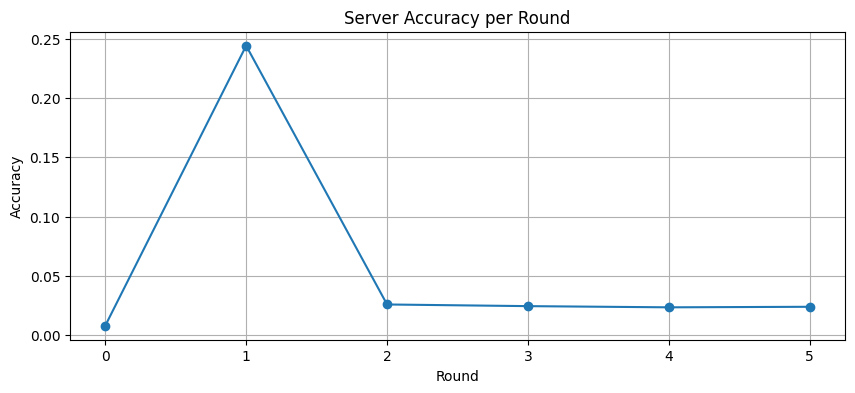

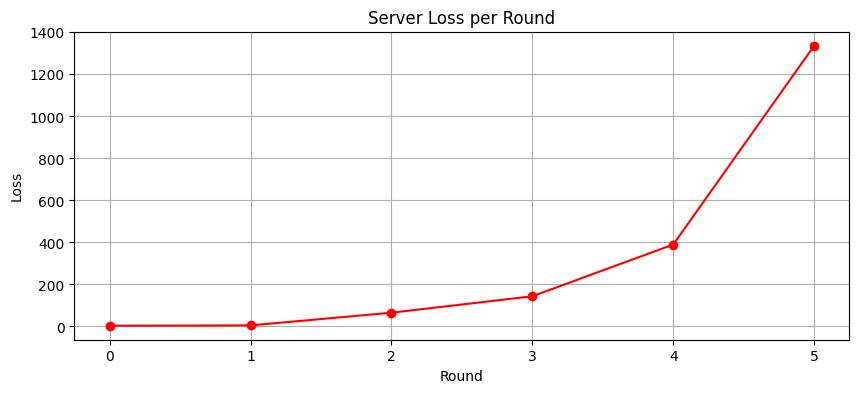

In [40]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
